In [1]:
import tensorflow as tf
import numpy as np
import os
import re
import io
import librosa
import pickle
import random
import matplotlib.pyplot as plt
import IPython.display as ipd
from os.path import isdir, join
%matplotlib inline

In [46]:
data_dir = "/home/maikfangogoair/tmp/save/"
pkl_file = "spect_v1.pkl"
with open (data_dir + pkl_file, 'rb') as fp:
    all_data = pickle.load(fp)

In [7]:
tf.reset_default_graph();
input=tf.placeholder(tf.float32, (None, 99, 161), 'input')
def spectrogram_ConvNet(input):
    """
    """
    dropout_prob = tf.placeholder(tf.float32, name='dropout_prob')
    
    
    reshape_input = tf.reshape(input, [-1, 99, 161, 1], 'reshape_input')
    batch_input = tf.layers.batch_normalization(reshape_input)
    
    conv_1 = tf.layers.conv2d(batch_input, 64, (5,5), (1,1), 'same', name='conv_1')
    relu_1 = tf.nn.relu(conv_1,'relu_1')
    dropout_1 = tf.nn.dropout(relu_1, dropout_prob, name = 'dropout_1')
    
    max_pool = tf.nn.max_pool(dropout_1, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME')

    conv_2 = tf.layers.conv2d(max_pool, 64, (3,3), (1,1), 'same')
    relu_2 = tf.nn.relu(conv_2,'relu_2')
    dropout_2 = tf.nn.dropout(relu_2, dropout_prob, name = 'dropout_2')
    
    size=int(dropout_2.get_shape()[1]) * int(dropout_2.get_shape()[2]) * int(dropout_2.get_shape()[3])
    flatten = tf.reshape(dropout_2, (-1, size), 'flatten')

    logits = tf.layers.dense(flatten, 12,name = 'logits')
    
    return logits,dropout_prob

In [56]:
tf.reset_default_graph();
input=tf.placeholder(tf.float32, (None, 1, 161, 101))
              
def VGG11(input, final_class, verbose):
    steps = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']
    dropout_prob = tf.placeholder(tf.float32, name='dropout_prob')
    features = tf.transpose(input,[0, 2, 3, 1])
    if verbose: print(features)
    for i in range(len(steps)):
        step = steps[i]
        with tf.variable_scope("Layer"+str(i+1), reuse=False):
            if step == 'M':
                features = tf.layers.max_pooling2d(features , (2,2) , (2,2) ,"same")
                if verbose: print(features)
            else:
                features = tf.layers.conv2d(features, step, (3,3), (1,1), 'same', name='conv_1')
                if verbose: print(features)
                features = tf.layers.batch_normalization(features)
                if verbose: print(features)
                features = tf.nn.relu(features)
                if verbose: print(features)
    features = tf.layers.average_pooling2d(features , (1,1), (1,1), 'same')
    if verbose: print(features)
    features = tf.layers.flatten(features)
    if verbose: print(features)
    features = tf.layers.dense(features, 512)
    if verbose: print(features)
    logits = tf.layers.dense(features, final_class )
    if verbose: print(features)
    
    return logits,dropout_prob

In [57]:
model_name = "VGG11"
model_cfg = {"spectrogram_ConvNet": spectrogram_ConvNet, "VGG11": VGG11}
model = model_cfg[model_name]
final_class = 30
logits,dropout_prob = model(input, final_class, False)

In [60]:
#training steps
ground_truth_input = tf.placeholder(tf.int64, [None], name='groundtruth_input')
learning_rate_input = tf.placeholder(tf.float32, [], name='learning_rate_input')
cross_entropy_mean = tf.losses.sparse_softmax_cross_entropy(ground_truth_input, logits)
#train_step = tf.train.GradientDescentOptimizer(learning_rate_input).minimize(cross_entropy_mean)
train_step = tf.train.AdamOptimizer(learning_rate_input).minimize(cross_entropy_mean)

predicted_indices = tf.argmax(logits, 1)
correct_prediction = tf.equal(predicted_indices, ground_truth_input)
confusion_matrix = tf.confusion_matrix(ground_truth_input, predicted_indices, num_classes=12)
evaluation_step = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [ ]:
random.seed(1222)
size=len([x for x in all_data if x["group"] == "training" ])
saver = tf.train.Saver(tf.global_variables())
init = tf.global_variables_initializer()

batch_size = 100
learning_rate = 1e-3
learning_decay = 0.9
learning_decay_period = 1000
eval_every_steps = 50
training_steps = 1000
print_every = 10
eval_size = 300
save_every_steps = 300
validation_size = len([x["label_idx"] for x in all_data if x["group"] == "validation"])
print("validation set count:" + str(validation_size))

with tf.Session() as sess:
    sess.run(init)
    #saver.restore(sess, data_dir + 'VGG11.ckpt-2000')
    for i in range(1, training_steps+1):
        start_pos = (i-1) * batch_size % size
        end_pos = (i-1) * batch_size % size + batch_size 
        train_fingerprints = np.asarray([x["feature"] for x in all_data if x["group"] == "training"][start_pos:end_pos])
        train_ground_truth = np.asarray([x["label_idx"] for x in all_data if x["group"] == "training"][start_pos:end_pos]) 
        loss, _ ,accurancy,  = sess.run([cross_entropy_mean, train_step, evaluation_step], \
                feed_dict={
                    input: train_fingerprints,
                    ground_truth_input: train_ground_truth,
                    learning_rate_input: learning_rate * (learning_decay**(i // learning_decay_period)),
                    dropout_prob: 0.5
                })
        if i % print_every == 0:
            print("Step %d, loss: %f, accurancy: %f." % (i, loss, accurancy))
        if  i % save_every_steps == 0:
            saver.save(sess, data_dir + model_name +".ckpt", global_step=i)
        if  i % eval_every_steps == 0:
            rand_choice = [random.randint(0,validation_size-1) for x in range(eval_size)]
            _, accurancy = sess.run([train_step,evaluation_step], \
                feed_dict={
                    input: np.asarray([x["feature"] for x in all_data if x["group"] == "validation"])[rand_choice],
                    ground_truth_input: np.asarray([x["label_idx"] for x in all_data if x["group"] == "validation"])[rand_choice], \
                    learning_rate_input: learning_rate * (learning_decay**(i // learning_decay_period)),
                    dropout_prob: 1.0
                })
            print("Validation accurancy is %f" % accurancy)

validation set count:6798
INFO:tensorflow:Restoring parameters from /home/maikfangogoair/tmp/save/VGG11.ckpt-2000


INFO:tensorflow:Restoring parameters from /home/maikfangogoair/tmp/save/VGG11.ckpt-2000


Step 10, loss: 0.061133, accurancy: 0.970000.
Step 20, loss: 0.162676, accurancy: 0.970000.
Step 30, loss: 0.052632, accurancy: 0.990000.
Step 40, loss: 0.144138, accurancy: 0.940000.
Step 50, loss: 0.185712, accurancy: 0.940000.
Validation accurancy is 0.910000
Step 60, loss: 0.090249, accurancy: 0.970000.
Step 70, loss: 0.240701, accurancy: 0.960000.
Step 80, loss: 0.051241, accurancy: 0.990000.
Step 90, loss: 0.090714, accurancy: 0.970000.
Step 100, loss: 0.180063, accurancy: 0.950000.
Validation accurancy is 0.930000
Step 110, loss: 0.047245, accurancy: 0.980000.
Step 120, loss: 0.141690, accurancy: 0.970000.
Step 130, loss: 0.118779, accurancy: 0.950000.
Step 140, loss: 0.165956, accurancy: 0.950000.
Step 150, loss: 0.110833, accurancy: 0.950000.
Validation accurancy is 0.933333
Step 160, loss: 0.122485, accurancy: 0.950000.
Step 170, loss: 0.075996, accurancy: 0.980000.
Step 180, loss: 0.197395, accurancy: 0.960000.
Step 190, loss: 0.123635, accurancy: 0.970000.
Step 200, loss: 0

In [71]:
train_audio_path = '/home/maikfangogoair/tmp/label_data/'
word_list = [x for x in os.listdir(train_audio_path) if os.path.isdir(train_audio_path + x) and x != '_background_noise_']
wanted_list = word_list

In [74]:
#testing
step_num = 10
test_set = [x for x in all_data if x["group"] == "testing"]
test_size = len(test_set) 
print("Testing set size is "+ str(test_size))
step_size = test_size // (step_num-1)
with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, data_dir + 'VGG11.ckpt-900')
    for i in range(step_num):
        start = i*step_size 
        end = min((i+1)*step_size , test_size)
        print("Testing from %d(include) to %d(exclude)..." % (start, end))
        predicted_list = sess.run(predicted_indices, \
            feed_dict={
                input: np.asarray([x["feature"] for x in test_set][start : end] ) ,
                dropout_prob: 1.0
            })
        if i == 0 :
            final_predicted_list = np.copy(predicted_list) 
        else:
            final_predicted_list = np.hstack((final_predicted_list, predicted_list))
print("Testing predicted list size is "+ str(len(final_predicted_list)))
wrong_list = []
for i in range(test_size):
    predicted_label_idx = final_predicted_list[i]
    if  predicted_label_idx != test_set[i]["label_idx"]:
        test_set[i]["predicted_label_idx"] = predicted_label_idx
        test_set[i]["predicted_label"] = wanted_list[predicted_label_idx]
        wrong_list.append(test_set[i])
print("There are %d wrong predictions in total %d data. Predictions accurancy is: %f" % \
      (len(wrong_list), test_size, (test_size - len(wrong_list)) / test_size))

Testing set size is 6835
INFO:tensorflow:Restoring parameters from /home/maikfangogoair/tmp/save/VGG11.ckpt-900


INFO:tensorflow:Restoring parameters from /home/maikfangogoair/tmp/save/VGG11.ckpt-900


Testing from 0(include) to 759(exclude)...
Testing from 759(include) to 1518(exclude)...
Testing from 1518(include) to 2277(exclude)...
Testing from 2277(include) to 3036(exclude)...
Testing from 3036(include) to 3795(exclude)...
Testing from 3795(include) to 4554(exclude)...
Testing from 4554(include) to 5313(exclude)...
Testing from 5313(include) to 6072(exclude)...
Testing from 6072(include) to 6831(exclude)...
Testing from 6831(include) to 6835(exclude)...
Testing predicted list size is 6835
There are 601 wrong predictions in total 6835 data. Predictions accurancy is: 0.912070


In [75]:
def confuse_map(wrong_list):
    confuse_map = {}
    for x in wrong_list:
        key = x["label"] + " is confused by " + x["predicted_label"]
        cnt = confuse_map.get(key, 0)
        confuse_map[key] = cnt + 1 
    #https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value
    import operator
    sorted_confuse_map = sorted(confuse_map.items(), key=operator.itemgetter(1), reverse=True)
    return sorted_confuse_map

confuse_map(wrong_list)

[('no is confused by go', 50),
 ('no is confused by down', 27),
 ('tree is confused by three', 21),
 ('three is confused by tree', 20),
 ('eight is confused by six', 18),
 ('two is confused by go', 14),
 ('down is confused by go', 13),
 ('left is confused by yes', 10),
 ('off is confused by up', 8),
 ('dog is confused by go', 8),
 ('off is confused by on', 8),
 ('left is confused by six', 7),
 ('right is confused by five', 7),
 ('five is confused by right', 6),
 ('right is confused by bed', 5),
 ('happy is confused by six', 5),
 ('one is confused by right', 5),
 ('wow is confused by go', 5),
 ('dog is confused by down', 5),
 ('nine is confused by right', 5),
 ('off is confused by house', 5),
 ('no is confused by dog', 5),
 ('left is confused by bed', 5),
 ('five is confused by on', 5),
 ('no is confused by three', 4),
 ('left is confused by right', 4),
 ('zero is confused by two', 4),
 ('nine is confused by five', 4),
 ('one is confused by on', 4),
 ('eight is confused by right', 4),
 

In [76]:
def get_spect(path, window_size=.02, window_stride=.01, window='hamming', normalize = True, max_len=101):
    y, sr = librosa.load(path, sr=None)
    n_fft = int(sr * window_size)
    win_length = n_fft
    hop_length = int(sr * window_stride)

    # STFT
    D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length,
                     win_length=win_length, window=window)
    spect, _ = librosa.magphase(D)
    # S = log(S+1)
    spect = np.log1p(spect)

    # make all spects with the same dims
    # TODO: change that in the future
    if spect.shape[1] < max_len:
        pad = np.zeros((spect.shape[0], max_len - spect.shape[1]))
        spect = np.hstack((spect, pad))
    elif spect.shape[1] > max_len:
        spect = spect[:max_len, ]
    spect = np.resize(spect, (1, spect.shape[0], spect.shape[1]))
    if normalize:
        mean = spect.mean()
        std = spect.std()
        if std != 0:
            spect = (spect - mean) /std

    return spect

In [134]:
test_audio_path = '/home/maikfangogoair/test/audio/'
files = [x for x in os.listdir(test_audio_path) if x.endswith('.wav') or x.endswith('.WAV')]
test_size = len(files)
batch_size = 300
with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, data_dir + 'VGG11.ckpt-900')
    for  i in range(0, len(files), batch_size):
        end = min(i + batch_size, test_size)
        print("Testing from %d(include) to %d(exclude)..." % (i, end))
        batch_data = []
        for j in range(i, end):
            spect = get_spect(test_audio_path + files[j])
            batch_data.append({"filename":files[j], "feature":spect})
            
        predicted_list = sess.run(predicted_indices, \
                feed_dict={
                    input: np.asarray([x["feature"] for x in batch_data] ) ,
                    dropout_prob: 1.0
                })
        
        if i == 0 :
            final_predicted_list = np.copy(predicted_list) 
            wild_test_data = batch_data
        else:
            final_predicted_list = np.hstack((final_predicted_list, predicted_list))
            wild_test_data += batch_data

INFO:tensorflow:Restoring parameters from /home/maikfangogoair/tmp/save/VGG11.ckpt-900


INFO:tensorflow:Restoring parameters from /home/maikfangogoair/tmp/save/VGG11.ckpt-900


Testing from 0(include) to 300(exclude)...
Testing from 300(include) to 600(exclude)...
Testing from 600(include) to 900(exclude)...
Testing from 900(include) to 1200(exclude)...
Testing from 1200(include) to 1500(exclude)...
Testing from 1500(include) to 1800(exclude)...
Testing from 1800(include) to 2100(exclude)...
Testing from 2100(include) to 2400(exclude)...
Testing from 2400(include) to 2700(exclude)...
Testing from 2700(include) to 3000(exclude)...
Testing from 3000(include) to 3300(exclude)...
Testing from 3300(include) to 3600(exclude)...
Testing from 3600(include) to 3900(exclude)...
Testing from 3900(include) to 4200(exclude)...
Testing from 4200(include) to 4500(exclude)...
Testing from 4500(include) to 4800(exclude)...
Testing from 4800(include) to 5100(exclude)...
Testing from 5100(include) to 5400(exclude)...
Testing from 5400(include) to 5700(exclude)...
Testing from 5700(include) to 6000(exclude)...
Testing from 6000(include) to 6300(exclude)...
Testing from 6300(incl

In [135]:
competition_list = ['silence', 'unknown', 'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
if 1==1:
# if len(wild_test_data) == final_predicted_list.shape[0]:
#     final_predicted_list = final_predicted_list.tolist()
    with io.open("/home/maikfangogoair/tensorflow-speech-recognition-challenge/submit_entry_3.csv",mode='w', encoding='utf-8') as f:
        for i in range(len(wild_test_data)):
            wanted_label = wanted_list[final_predicted_list[i]]
            if wanted_label in competition_list : 
                label = wanted_label
            else: 
                label = "unknown"
            wild_test_data[i]["predicted_label"] = label
            if i == 0:
                f.write("fname,label\n")
            f.write(wild_test_data[i]["filename"] + "," + label + "\n")
else :
    "Data and predictions count unmatch !"

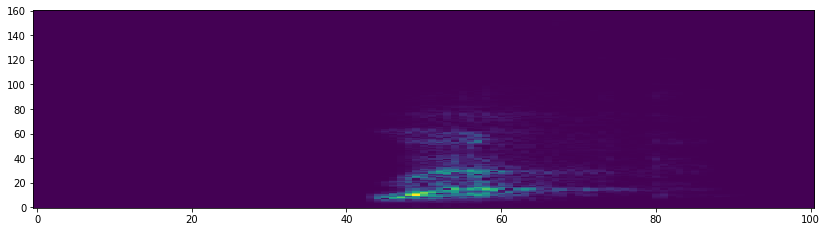

In [131]:
file="clip_4c92c8cb7.wav"
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.imshow(np.squeeze(get_spect(test_audio_path + file ), axis=0) , aspect='auto', origin='lower')
ipd.Audio(join(test_audio_path, file))

In [136]:
#Your submission scored 0.71, which is not an improvement of your best score. Keep trying!